## Introduction

Forests and vegetation have always been central to the survival of humans on earth. They provide the air we breathe, the food we eat and the materials used to construct our homes. Thanks to loads of fascinating research projects, there are several open source datasets illustrating the distribution of forests and vegetation on earth. With the magic of Python we can take these datasets, analyse them, manipulate them and use them to generate insightful and eye-catching visualisations like the one shown above.

While data visualisation is the aim of the game so to speak, this is an exercise with data manipulation and reprojection at its core. We will use rasterio and rioxarray generate the visualisation above as well as some other interesting plots.

### Data Exploration

There are a number of datasets out there and in this tutorial we will use Percent Tree Coverage (PTC) dataset from the Geospatial Information Authority of Japan, Chiba University and collaborating organizations (link to dataset and license information).

The data is quite old and shows forests from 2003, which is obviously quite a long time ago, however the methods used here will be applicable to other forest datasets and or indeed for some of the more recent (but much larger) data stored within this repository. Indeed, a higher resolution dataset exists within this repository however the data is broken down into 12 separate tif files representing 90x60 degree chunks of the world. Combining different tif files is possible but out of scope for this particular tutorial and hence will be covered in a future article.

The data is stored in a tif file and the resolution is 30 arcseconds (~1 square km). In each gridpoint of the tif file there is a value between 0–100 corresponding to the percentage tree cover within that 1 square km area. Water bodies are given a value of 254 and no data is given 255.

Below the data is opened and read using rasterio. Note that the file is loaded and opened in two different steps. The minimum and maximum values are printed using numpy to show that the value ranges from 0–254 meaning there is no missing data.

In [1]:
import matplotlib.pyplot as plt

logo = plt.imread('resources/globe_black.png')

In [2]:
import rasterio
import numpy as np

forests_file = rasterio.open('../Nature/Forests/data/gm_ve_v1.tif')
forests = forests_file.read()

print(np.amin(forests))
print(np.amax(forests))
print(len(np.unique(forests)))

0
254
102


With any data visualisation problem the first thing to do is to plot the data to get a sense for what we are dealing with. Below is a standard imshow plot of the data using the Greens colourmap (because why would you use anything else for forests?).

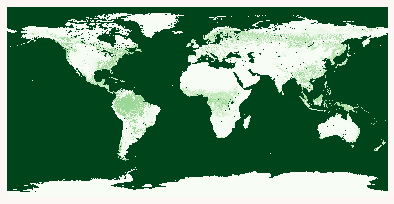

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(facecolor='#FCF6F5FF')

ax = plt.axes()
fig.set_size_inches(7, 3.5)
ax.patch.set_facecolor('#FCF6F5FF')

imgs = plt.imshow(forests[0],
                  cmap='Greens',
                  interpolation='nearest')

ax.axis('off')
plt.show()

The obvious issue is that the oceans have been coloured green and there are clearly no forests there. The data is scaled between 0–100 for the percentage tree coverage but there is an additional data point for the water bodies — 254. When plotting the data matplotlib creates a colourmap with colours scaled linearly between the smallest value (0) and largest value (254) in the dataset. The data that we actually care about is mapped to the first 101 colours (~40% of the colourmap), there are 153 colours that are completely unused (101–253) and one colour is used for the oceans (254). So ~60% of the colours in the colourmap are not used. This is illustrated visually below.

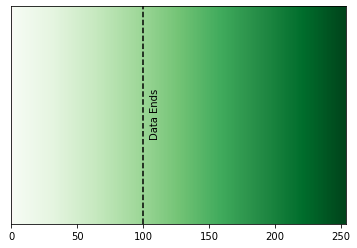

In [4]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib import cm

purples = cm.get_cmap('Greens', 254)
newcolors = purples(np.linspace(0, 1, 254))
background_colour = np.array([0.9882352941176471, 0.9647058823529412, 0.9607843137254902, 1.0])
#pink = np.array([0,0,0, 1.0])
newcolors[:1, :] = background_colour
newcmp_forests = ListedColormap(newcolors)

bounds = np.arange(254)
norm_forests = BoundaryNorm(bounds, newcmp_forests.N)

gradient = np.linspace(0, 1, 254)
gradient = np.vstack((gradient, gradient))
fig, ax = plt.subplots()
ax.imshow(gradient, aspect='auto', cmap=newcmp_forests)
ax.get_yaxis().set_visible(False)
ax.axvline(100, ls="--", c='black', )
plt.text(105, 0.7, "Data Ends", rotation=90)

plt.show()

For the purpose of this exercise, we are going to assume that oceans have 0% tree coverage, which is probably a pretty safe assumption but at the very least worth mentioning, and hence, in the code below, all values greater than 100 are changed to 0. So in subsequent plots, there will be 101 values (0–100) and the colourmap will map perfectly to the lowest (areas with 0 forest cover and water bodies) to the highest (100% forest cover) values.

I want to set a custom background colour for gridpoints with 0 forest cover so we use the code below to generate a colourmap with 101 colours, replace the first colour with our custom value and then create a new colourmap from that list of colours.

To create a colourmap from a list of colours we can use the ListedColormap method which takes a list of colours and generates a colourmap from those colours. As the data is a linear range of value between 0–100 we don’t need to worry about boundaries and we can use a colourmap without normalising the colourmap (for more information on colourmaps and normalising colourmaps, I have written extensively about them here).

In [5]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib import cm

forests[0][forests[0] == 254] = 0.0

ourcmap = cm.get_cmap('Greens', 101)
newcolors = ourcmap(np.linspace(0, 1, 101))
background_colour = np.array([0.9882352941176471, 0.9647058823529412, 0.9607843137254902, 1.0])
newcolors[:1, :] = background_colour
newcmp_forests = ListedColormap(newcolors)

The colourmap can then be applied to the plotting code generated earlier. There are a few additions here though, the axes have been turned off to make the plot look more artistic and the edges of the plot have been clipped to reduce the amount of white space. These are style changes which anyone attempting this tutorial can and indeed are encouraged to ignore. Data visualisation should be as much about expression than science and hence everyone should develop their own style.

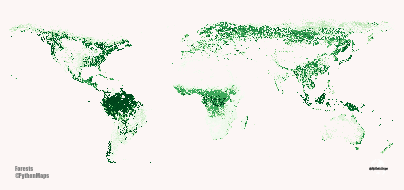

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(facecolor='#FCF6F5FF')

ax = plt.axes()
fig.set_size_inches(7, 3.5)
ax.patch.set_facecolor('#FCF6F5FF')

imgs = plt.imshow(forests[0],
                  cmap=newcmp_forests,
                  interpolation='nearest')

newax = fig.add_axes([0.8, 0.17, 0.08, 0.08], anchor='NE')
newax.imshow(logo)
newax.axis('off')
txt = ax.text(0.02, 0.03, "Forests \n@PythonMaps",
              size=6,
              color='grey',
              transform = ax.transAxes,
              fontfamily='fantasy')


ax.set_xlim(2000, 43500)
ax.set_ylim(19500, 800)
ax.axis('off')
plt.show()

The data looks as expected and it is important to look at a visualisation and ask yourself if it makes sense. There is clearly an issue with how the colourmap copes with water bodies, which will be addressed below but generally things are as expected. There are deep green areas corresponding to the Amazon, Congo and in South East Asia rainforests, the Northern Hemisphere shows continuous areas of lighter green corresponding to the deciduous forests of North America and Eurasia and there is even a slim green area of rainforest on the northern coastline of Iran.

We could end it there however I prefer maps with the Robinson projection so there is an additional step required to reproject the data. The Robinson projection is one of the more realistic ways to plot global datasets, accounting for the fact that the earth is not flat.

Reprojecting geospatial shapes like points and polygons is trivial but unfortunately doing the same with raster data is more challenging. To accomplish this we can us rioxarray. rioxarray extends xarray with the rio accessor and allows rasters from tiff and geotiff files to be clipped, merged and reprojected. Below, the original tif file is opened with rioxarray (it leverages some underlying rasterio functionality, hence the open_rasterio method), the Robinson projection is defined as a rasterio.CRS object and then the raster is reprojected onto this CRS. One thing to note, therasterio.CRS object is created from a pyproj string. pyproj is a fantastic library that deals with cartographic projections and coordinate transformations and is something I will cover in a future article.

In [ ]:
import rioxarray as rxr

forests_file = rxr.open_rasterio('../Nature/Forests/data/gm_ve_v1.tif', masked=True).squeeze()
print("Original projection: ", forests_file.rio.crs)
crs_rob = CRS.from_string('+proj=robin')
forests = forests_file.rio.reproject(crs_rob)
print("New projection: ", forests.rio.crs)
forests = forests.to_numpy()

print(np.amin(forests))
print(np.amax(forests))
print(forests.shape)
print(len(np.unique(forests)))


The data can then be plotted using the same colourmap as before to give us our forests map in the Robinson projection.

In [ ]:
forests[forests > 100] = 0.0


fig = plt.figure(facecolor='#FCF6F5FF')

ax = plt.axes()
fig.set_size_inches(7, 3.5)
ax.patch.set_facecolor('#FCF6F5FF')

imgs = plt.imshow(forests,
                  cmap=newcmp_forests,
                  interpolation='nearest')
ax.axis('off')
ax.set_xlim(2000, 43500)
ax.set_ylim(19500, 800)

newax = fig.add_axes([0.8, 0.17, 0.08, 0.08], anchor='NE')
newax.imshow(logo)
newax.axis('off')
txt = ax.text(0.02, 0.03, "Forests \n@PythonMaps",
              size=6,
              color='grey',
              transform = ax.transAxes,
              fontfamily='fantasy')

plt.show()

One side point, when using linear, single colour colourmaps, it is often possible to lose data at the lighter end of the colourmap so for fun, you can use a weird and wonderful colourmap so that every data point is shown clearly, 0–100. Below is the same plot as before but this time using the gnuplot colourmap.

A few things will now jump out, the wild west in the USA, large parts of South America, parts of the Sahara, Central Asia, Australia and South Africa, which have very small forest cover percentages now show up. The Nile river and delta appear as well. The green colourmap used in this article is entirely appropriate for the task at hand however it is still useful to explore others just to get a full understanding of the data as well as to create interesting plots.

In [ ]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib import cm

purples = cm.get_cmap('gnuplot', 101)
newcolors = purples(np.linspace(0, 1, 101))
background_colour = np.array([0.9882352941176471, 0.9647058823529412, 0.9607843137254902, 1.0])
newcolors[:1, :] = background_colour
newcmp_forests = ListedColormap(newcolors)

In [ ]:
fig = plt.figure(facecolor='#FCF6F5FF')

ax = plt.axes()
fig.set_size_inches(7, 3.5)
ax.patch.set_facecolor('#FCF6F5FF')

imgs = plt.imshow(forests,
                  cmap=newcmp_forests,
                  interpolation='nearest')
ax.axis('off')
ax.set_xlim(2000, 43500)
ax.set_ylim(19500, 800)

newax = fig.add_axes([0.8, 0.17, 0.08, 0.08], anchor='NE')
newax.imshow(logo)
newax.axis('off')
txt = ax.text(0.02, 0.03, "Forests \n@PythonMaps",
              size=6,
              color='grey',
              transform = ax.transAxes,
              fontfamily='fantasy')

plt.show()

https://neo.gsfc.nasa.gov/